In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import os
import joblib

2025-03-08 11:18:59.990965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 11:18:59.991635: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 11:18:59.994705: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 11:19:00.004766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741403940.026858    5841 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741403940.03

In [2]:
def create_sequences(data, targets, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(targets[i + window_size])
    return np.array(X), np.array(y)

In [3]:
def add_temporal_features(df):
    df['HourSin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['HourCos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DaySin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayCos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['MonthSin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['MonthCos'] = np.cos(2 * np.pi * df['Month'] / 12)
    return df

In [4]:
def add_lagged_features(df, target_column, lags):
    for lag in lags:
        df[f'{target_column}_lag_{lag}'] = df[target_column].shift(lag)
    return df.dropna()

In [5]:
def load_and_preprocess_data(files, sheets):
    df_list = []
    
    for file in files:
        if os.path.exists(file):
            for sheet in sheets:
                try:
                    temp_df = pd.read_excel(file, sheet_name=sheet)
                    
                    if 'TRAFFIC STATUS' in temp_df.columns:
                        temp_df.drop(columns=['TRAFFIC STATUS'], inplace=True)
                    
                    temp_df['TIME(24 HOUR)'] = temp_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
                    temp_df['Datetime'] = pd.to_datetime(
                        temp_df['DATE'].astype(str) + ' ' + temp_df['TIME(24 HOUR)'],
                        dayfirst=True, errors='coerce'
                    )
                    
                    temp_df = temp_df.dropna(subset=['Datetime']).sort_values('Datetime')
                    temp_df['Hour'] = temp_df['Datetime'].dt.hour
                    temp_df['DayOfWeek'] = temp_df['Datetime'].dt.dayofweek
                    temp_df['Month'] = temp_df['Datetime'].dt.month
                    temp_df = add_temporal_features(temp_df)
                    
                    df_list.append(temp_df)
                except Exception as e:
                    print(f"Error loading {file} - {sheet}: {e}")
    
    return pd.concat(df_list, ignore_index=True) if df_list else None

In [6]:
files = ['./dataset/MA-A.xlsx', './dataset/NORTHBOUND.xlsx', './dataset/SOUTHBOUND.xlsx']
sheets = ["2018", "2019", "2020", "2021", "2022", "2023"]
df = load_and_preprocess_data(files, sheets)

df.head()

,DATE,TIME(24 HOUR),DAY OF THE WEEK,WEATHER,ROAD CONDITION,HOLIDAY,ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,HourSin,HourCos,DaySin,DayCos,MonthSin,MonthCos
0,01/01/2018,00:00:00,Monday,Passing Clouds,Dry,YES,0,36,224,2018-01-01 00:00:00,0,0,1,0.000000,1.000000,0.0,1.0,0.5,0.866025
1,01/01/2018,01:00:00,Monday,Passing Clouds,Dry,YES,0,27,171,2018-01-01 01:00:00,1,0,1,0.258819,0.965926,0.0,1.0,0.5,0.866025
2,01/01/2018,02:00:00,Monday,Passing Clouds,Dry,YES,0,24,119,2018-01-01 02:00:00,2,0,1,0.500000,0.866025,0.0,1.0,0.5,0.866025
3,01/01/2018,03:00:00,Monday,Passing Clouds,Dry,YES,0,22,173,2018-01-01 03:00:00,3,0,1,0.707107,0.707107,0.0,1.0,0.5,0.866025
4,01/01/2018,04:00:00,Monday,Passing Clouds,Dry,YES,0,38,168,2018-01-01 04:00:00,4,0,1,0.866025,0.500000,0.0,1.0,0.5,0.866025


In [7]:
categorical_cols = ['DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

target_column = 'TRAFFIC VOLUME'

# lags = [1, 2, 3, 6, 12, 24]
# df = add_lagged_features(df, target_column, lags)

features = df.drop([target_column, 'DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1)
target = df[target_column]

scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(target.values.reshape(-1, 1)).flatten()

window_size = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

df.head()

,DATE,TIME(24 HOUR),ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,HourSin,...,DAY OF THE WEEK_Thursday,DAY OF THE WEEK_Tuesday,DAY OF THE WEEK_Wednesday,WEATHER_Overcast,WEATHER_Passing Clouds,WEATHER_Rainy,WEATHER_Sunny,WEATHER_Thunderstorm,ROAD CONDITION_Wet,HOLIDAY_YES
0,01/01/2018,00:00:00,0,36,224,2018-01-01 00:00:00,0,0,1,0.000000,...,False,False,False,False,True,False,False,False,False,True
1,01/01/2018,01:00:00,0,27,171,2018-01-01 01:00:00,1,0,1,0.258819,...,False,False,False,False,True,False,False,False,False,True
2,01/01/2018,02:00:00,0,24,119,2018-01-01 02:00:00,2,0,1,0.500000,...,False,False,False,False,True,False,False,False,False,True
3,01/01/2018,03:00:00,0,22,173,2018-01-01 03:00:00,3,0,1,0.707107,...,False,False,False,False,True,False,False,False,False,True
4,01/01/2018,04:00:00,0,38,168,2018-01-01 04:00:00,4,0,1,0.866025,...,False,False,False,False,True,False,False,False,False,True


In [8]:
print("Training Features:", list(df.columns))

Training Features: ['DATE', 'TIME(24 HOUR)', 'ACCIDENTS', 'AVERAGE SPEED', 'TRAFFIC VOLUME', 'Datetime', 'Hour', 'DayOfWeek', 'Month', 'HourSin', 'HourCos', 'DaySin', 'DayCos', 'MonthSin', 'MonthCos', 'DAY OF THE WEEK_Monday', 'DAY OF THE WEEK_Saturday', 'DAY OF THE WEEK_Sunday', 'DAY OF THE WEEK_Thursday', 'DAY OF THE WEEK_Tuesday', 'DAY OF THE WEEK_Wednesday', 'WEATHER_Overcast', 'WEATHER_Passing Clouds', 'WEATHER_Rainy', 'WEATHER_Sunny', 'WEATHER_Thunderstorm', 'ROAD CONDITION_Wet', 'HOLIDAY_YES']


In [9]:
model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu', kernel_regularizer=L2(0.01)),
    Dropout(0.3),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.3,
    callbacks=[early_stop],
    verbose=1
)

y_pred_scaled = model.predict(X_test).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

2025-03-08 11:19:39.807525: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - loss: 0.1769 - mae: 0.0795 - val_loss: 0.0218 - val_mae: 0.0921
Epoch 2/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 29s 54ms/step - loss: 0.0072 - mae: 0.0576 - val_loss: 0.0140 - val_mae: 0.0757
Epoch 3/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0059 - mae: 0.0506 - val_loss: 0.0111 - val_mae: 0.0655
Epoch 4/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0052 - mae: 0.0474 - val_loss: 0.0088 - val_mae: 0.0608
Epoch 5/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0049 - mae: 0.0461 - val_loss: 0.0096 - val_mae: 0.0621
Epoch 6/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 55ms/step - loss: 0.0044 - mae: 0.0434 - val_loss: 0.0099 - val_mae: 0.0635
Epoch 7/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0042 - mae: 0.0426 - val_loss: 0.0105 - val_mae: 0.0623
Epoch 8/100
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 56ms/step - loss: 0.0040 - mae: 0.0413 - val_loss: 0.0092 - val_mae: 0.0609
Epoch 9/100
545/545 ━━━━━━━━━━━━

In [10]:
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_actual, y_pred)

print("\nPerformance on training:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")


Performance on training:
MAE: 347.8849
MSE: 238918.0154
RMSE: 488.7924
R2 Score: 0.8714


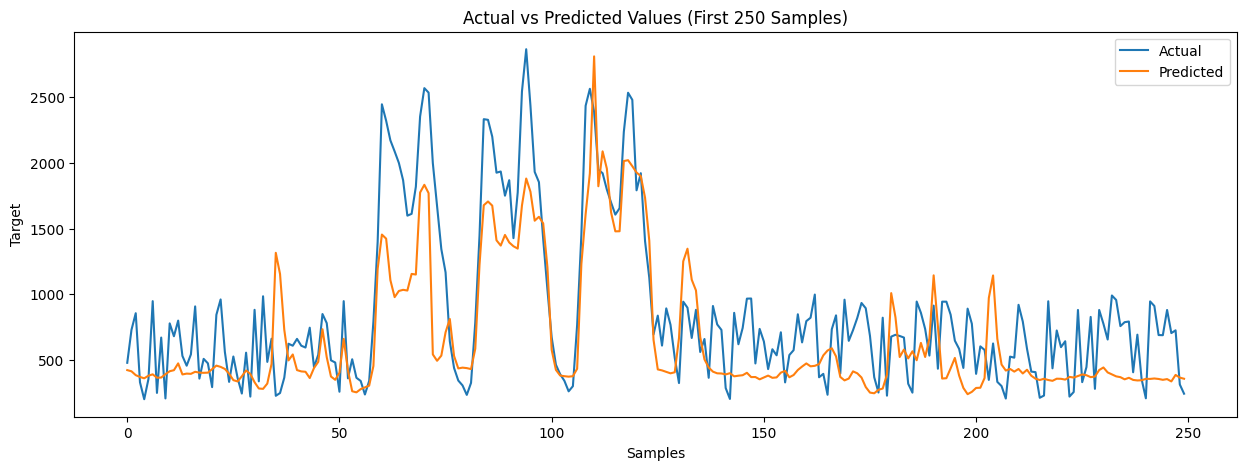

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[:250], label="Actual")
plt.plot(y_pred[:250], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

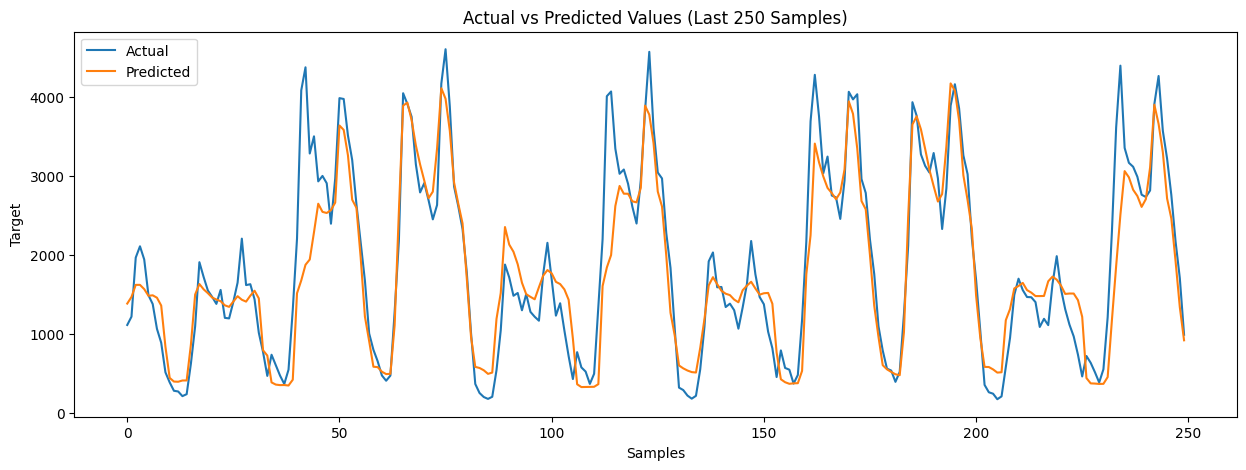

In [12]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual[-250:], label="Actual")
plt.plot(y_pred[-250:], label="Predicted")
plt.title("Actual vs Predicted Values (Last 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

In [24]:
# Function to preprocess new dataset
def preprocess_new_data(df, scaler_X, window_size):
    df['HourSin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['HourCos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DaySin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DayCos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['MonthSin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['MonthCos'] = np.cos(2 * np.pi * df['Month'] / 12)

    df = pd.get_dummies(df, columns=['DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY'], drop_first=True)

    # ✅ Save actual values before dropping
    y_actual = df['TRAFFIC VOLUME'].values if 'TRAFFIC VOLUME' in df.columns else None

    # Drop 'TRAFFIC VOLUME' since it's our target
    df = df.drop(columns=['TRAFFIC VOLUME'], errors='ignore')

    features = df.drop(['DATE', 'TIME(24 HOUR)', 'Datetime'], axis=1, errors='ignore')

    X_scaled = scaler_X.transform(features)

    X_seq = []
    for i in range(len(X_scaled) - window_size):
        X_seq.append(X_scaled[i:i + window_size])

    return np.array(X_seq), y_actual[window_size:] if y_actual is not None else None

In [25]:
# Load new dataset
new_data_file = './dataset/TESTING_DATASET.xlsx'
new_df = pd.read_excel(new_data_file)
if 'TRAFFIC STATUS' in new_df.columns:
    new_df.drop(columns=['TRAFFIC STATUS'], inplace=True)
new_df['ROAD CONDITION'] = new_df['ROAD CONDITION'].str.capitalize()
new_df['TIME(24 HOUR)'] = new_df['TIME(24 HOUR)'].astype(str).str.zfill(5) + ':00'
new_df['Datetime'] = pd.to_datetime(new_df['DATE'].astype(str) + ' ' + new_df['TIME(24 HOUR)'], dayfirst=True, errors='coerce')
new_df = new_df.dropna(subset=['Datetime']).sort_values('Datetime')
new_df['Hour'] = new_df['Datetime'].dt.hour
new_df['DayOfWeek'] = new_df['Datetime'].dt.dayofweek
new_df['Month'] = new_df['Datetime'].dt.month

new_df.head()

,DATE,TIME(24 HOUR),DAY OF THE WEEK,WEATHER,ROAD CONDITION,HOLIDAY,ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month
0,01/01/2016,00:00:00,Friday,Clear,Dry,YES,0,39,342,2016-01-01 00:00:00,0,4,1
1,01/01/2016,01:00:00,Friday,Clear,Dry,YES,0,29,232,2016-01-01 01:00:00,1,4,1
2,01/01/2016,02:00:00,Friday,Clear,Dry,YES,0,39,200,2016-01-01 02:00:00,2,4,1
3,01/01/2016,03:00:00,Friday,Clear,Dry,YES,0,31,183,2016-01-01 03:00:00,3,4,1
4,01/01/2016,04:00:00,Friday,Clear,Dry,YES,0,38,222,2016-01-01 04:00:00,4,4,1


In [26]:
# Preprocess new data
window_size = 24
X_new, y_actual_new = preprocess_new_data(new_df, scaler_X, window_size)

new_df.head()

,DATE,TIME(24 HOUR),DAY OF THE WEEK,WEATHER,ROAD CONDITION,HOLIDAY,ACCIDENTS,AVERAGE SPEED,TRAFFIC VOLUME,Datetime,Hour,DayOfWeek,Month,HourSin,HourCos,DaySin,DayCos,MonthSin,MonthCos
0,01/01/2016,00:00:00,Friday,Clear,Dry,YES,0,39,342,2016-01-01 00:00:00,0,4,1,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025
1,01/01/2016,01:00:00,Friday,Clear,Dry,YES,0,29,232,2016-01-01 01:00:00,1,4,1,0.258819,0.965926,-0.433884,-0.900969,0.5,0.866025
2,01/01/2016,02:00:00,Friday,Clear,Dry,YES,0,39,200,2016-01-01 02:00:00,2,4,1,0.500000,0.866025,-0.433884,-0.900969,0.5,0.866025
3,01/01/2016,03:00:00,Friday,Clear,Dry,YES,0,31,183,2016-01-01 03:00:00,3,4,1,0.707107,0.707107,-0.433884,-0.900969,0.5,0.866025
4,01/01/2016,04:00:00,Friday,Clear,Dry,YES,0,38,222,2016-01-01 04:00:00,4,4,1,0.866025,0.500000,-0.433884,-0.900969,0.5,0.866025


In [27]:
print("Testing Features:", list(new_df.columns))
print(list(features));

Testing Features: ['DATE', 'TIME(24 HOUR)', 'DAY OF THE WEEK', 'WEATHER', 'ROAD CONDITION', 'HOLIDAY', 'ACCIDENTS', 'AVERAGE SPEED', 'TRAFFIC VOLUME', 'Datetime', 'Hour', 'DayOfWeek', 'Month', 'HourSin', 'HourCos', 'DaySin', 'DayCos', 'MonthSin', 'MonthCos']
['ACCIDENTS', 'AVERAGE SPEED', 'Hour', 'DayOfWeek', 'Month', 'HourSin', 'HourCos', 'DaySin', 'DayCos', 'MonthSin', 'MonthCos', 'DAY OF THE WEEK_Monday', 'DAY OF THE WEEK_Saturday', 'DAY OF THE WEEK_Sunday', 'DAY OF THE WEEK_Thursday', 'DAY OF THE WEEK_Tuesday', 'DAY OF THE WEEK_Wednesday', 'WEATHER_Overcast', 'WEATHER_Passing Clouds', 'WEATHER_Rainy', 'WEATHER_Sunny', 'WEATHER_Thunderstorm', 'ROAD CONDITION_Wet', 'HOLIDAY_YES']


In [28]:
# Ensure model is in memory
if 'model' not in globals():
    raise ValueError("Trained model not found. Ensure you have trained the model in a previous cell.")

In [29]:
# Make predictions
y_pred_scaled_new = model.predict(X_new).flatten()
y_pred_new = scaler_y.inverse_transform(y_pred_scaled_new.reshape(-1, 1)).flatten()

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step 


In [30]:
# Compute metrics
if y_actual_new is not None:
    mae_new = mean_absolute_error(y_actual_new, y_pred_new)
    mse_new = mean_squared_error(y_actual_new, y_pred_new)
    rmse_new = np.sqrt(mean_squared_error(y_actual_new, y_pred_new))
    r2_new = r2_score(y_actual_new, y_pred_new)

    print("\nPerformance on Testing:")
    print(f"MAE: {mae_new:.4f}")
    print(f"MSE: {mse_new:.4f}")
    print(f"RMSE: {rmse_new:.4f}")
    print(f"R2 Score: {r2_new:.4f}")
else:
    print("\nNo actual traffic volume data available for evaluation.")


Performance on Testing:
MAE: 229.8403
MSE: 98119.1641
RMSE: 313.2398
R2 Score: 0.6593


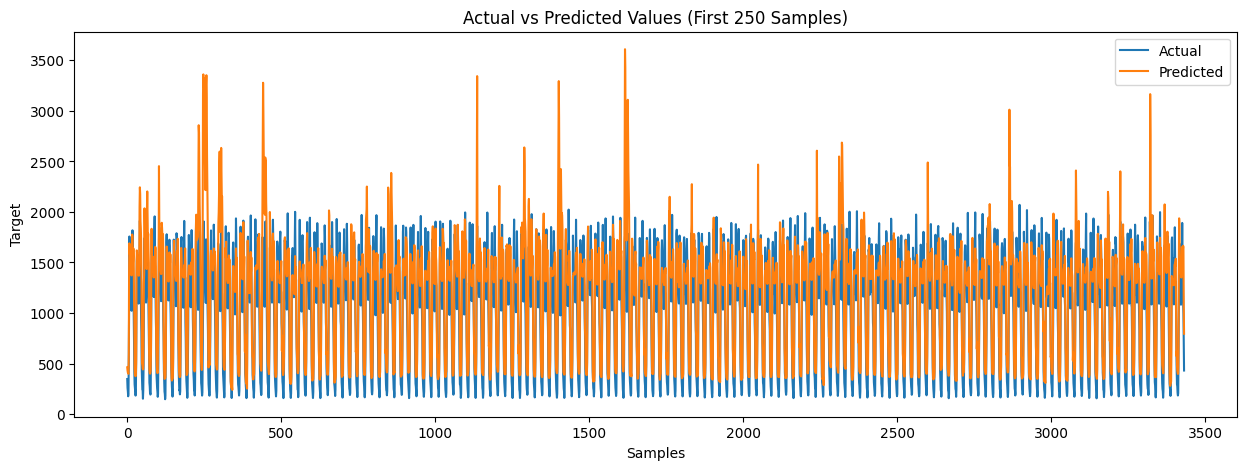

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new, label="Actual")
plt.plot(y_pred_new, label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

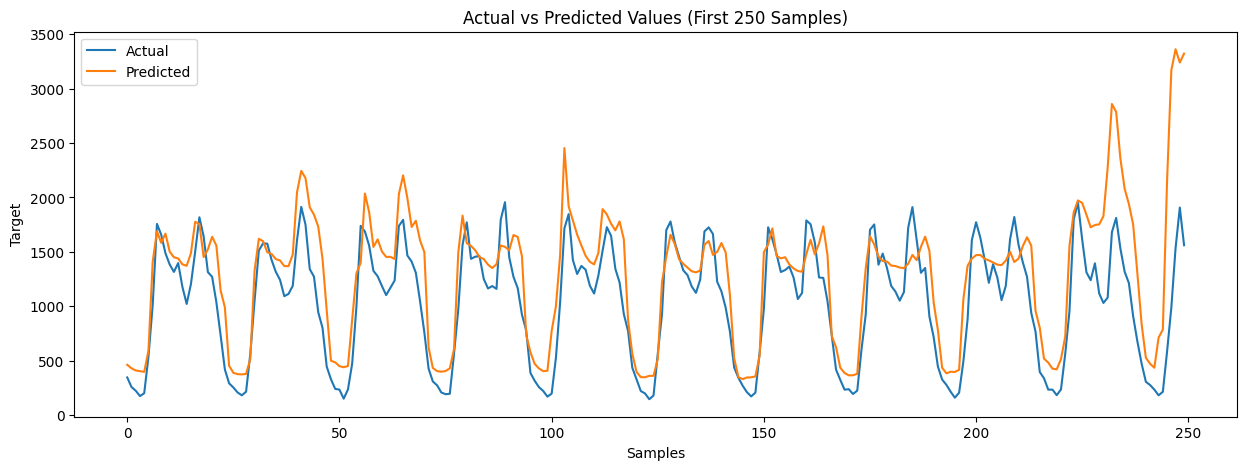

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new[:250], label="Actual")
plt.plot(y_pred_new[:250], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

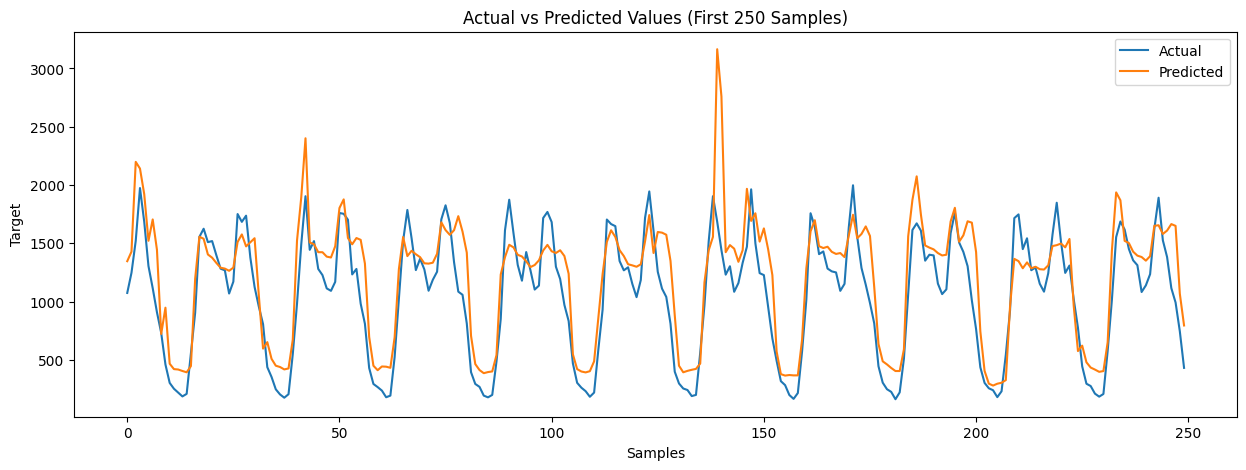

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(y_actual_new[-250:], label="Actual")
plt.plot(y_pred_new[-250:], label="Predicted")
plt.title("Actual vs Predicted Values (First 250 Samples)")
plt.xlabel("Samples")
plt.ylabel("Target")
plt.legend()
plt.show()

In [34]:
# Save the model
model.save("traffic_forecasting.h5")

In [35]:
# Save the scalers
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

In [49]:
joblib.dump(list(features.columns), "feature_names.pkl")

['feature_names.pkl']